In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function
import os
from collections import namedtuple
import numpy as np
import pandas as pd
import pyunfold
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

import comptools as comp

sns.set_context(context='paper', font_scale=1.5)
color_dict = comp.color_dict

%matplotlib inline

In [3]:
config = 'IC86.2012'
num_groups = 2

comp_list = comp.get_comp_list(num_groups=num_groups)
energybins = comp.get_energybins(config)
num_ebins = len(energybins.log_energy_midpoints)

unfolding_dir  = os.path.join(comp.paths.comp_data_dir,
                              config,
                              'unfolding')

In [4]:
feature_list, feature_labels = comp.get_training_features()

Load trained models

In [5]:
energy_pipeline = comp.load_trained_model('linearregression_energy_{}'.format(config))
pipeline_str = 'xgboost_comp_{}_{}-groups'.format(config, num_groups)
comp_pipeline = comp.load_trained_model(pipeline_str)

In [6]:
# Load DataFrame with saved prior distributions
df_file = os.path.join(unfolding_dir,
                       'unfolding-df_{}-groups.hdf'.format(num_groups))
df_priors = pd.read_hdf(df_file)
df_priors.head()

,counts,counts_err,efficiencies,efficiencies_err,broken_power_law_flux,broken_power_law_prior,simple_power_law_flux,simple_power_law_prior,H3a_flux,H3a_prior,H4a_flux,H4a_prior
log_energy_bin_idx,,,,,,,,,,,,
0,1071404.0,1035.086470,0.007119,0.000084,1.416780e-12,0.231674,1.416780e-12,0.231486,7.187420e-13,0.302586,7.333020e-13,0.306455
1,743932.0,862.514927,0.006400,0.000078,1.416780e-12,0.231674,1.416780e-12,0.231486,4.082709e-13,0.171880,4.023280e-13,0.168137
2,851277.0,922.646736,0.007928,0.000075,7.608561e-13,0.124416,7.608561e-13,0.124315,3.743101e-13,0.157582,3.821589e-13,0.159708
3,702982.0,838.440219,0.007473,0.000068,7.608561e-13,0.124416,7.608561e-13,0.124315,2.232925e-13,0.094005,2.198728e-13,0.091887
4,579872.0,761.493270,0.008373,0.000068,4.086039e-13,0.066816,4.086039e-13,0.066761,1.925426e-13,0.081059,1.967681e-13,0.082231


In [7]:
# Load fitted efficiencies and calculate effective areas
eff_path = os.path.join(comp.paths.comp_data_dir, config, 'efficiencies',
                        'efficiency_fit_num_groups_{}.hdf'.format(num_groups))
df_eff = pd.read_hdf(eff_path)
df_eff.head()

,eff_median_light,eff_err_low_light,eff_err_high_light,eff_median_heavy,eff_err_low_heavy,eff_err_high_heavy,eff_median_total,eff_err_low_total,eff_err_high_total
0,0.007119,0.000084,0.000077,0.006400,0.000078,0.000083,0.006739,0.000057,0.000053
1,0.007928,0.000075,0.000062,0.007473,0.000068,0.000072,0.007685,0.000044,0.000047
2,0.008373,0.000068,0.000063,0.008005,0.000064,0.000069,0.008194,0.000043,0.000046
3,0.008609,0.000070,0.000066,0.008268,0.000065,0.000067,0.008458,0.000046,0.000046
4,0.008735,0.000072,0.000068,0.008421,0.000063,0.000067,0.008606,0.000048,0.000045


In [8]:
# Get simulation thrown areas for each energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(energybins.log_energy_midpoints)
thrown_area = np.pi * thrown_radii.max()**2
thrown_area

9079202.768874502

In [9]:
efficiencies, efficiencies_err = comp.get_detector_efficiencies(config=config,
                                                                num_groups=num_groups,
                                                                sigmoid='slant',
                                                                pyunfold_format=True)

Load and process data

In [10]:
print('Loading data into memory...')
df_data = comp.load_data(config=config,
                         processed=True,
                         columns=feature_list,
                         n_jobs=15,
                         verbose=True)

# data_dir = os.path.join(comp.paths.comp_data_dir,
#                         'IC86.2012',
#                         'data')
# filepath_up_shift = os.path.join(data_dir, 
#                                 'data_dataframe_vem_cal_up.hdf')
# df_data = pd.read_hdf(filepath_up_shift,
#                       columns=feature_list)

Loading data into memory...
[########################################] | 100% Completed |  1min 33.3s


In [11]:
X_data = df_data[feature_list].values

In [12]:
print('Running composition classifications...')
df_data['pred_comp_target'] = comp_pipeline.predict(X_data)
print('Running energy regressions...')
df_data['reco_log_energy'] = energy_pipeline.predict(X_data)

Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Running energy regressions...


In [13]:
counts_observed = {}
counts_observed_err = {}

for comp_idx, composition in enumerate(comp_list):
    print(composition)
    # Filter out events that don't pass composition & energy mask
    pred_comp_mask = df_data['pred_comp_target'] == comp_idx
    mask = pred_comp_mask
    
    energies = df_data.loc[mask, 'reco_log_energy'].values
    comp_counts, _ = np.histogram(energies, bins=energybins.log_energy_bins)
    counts_observed[composition] = comp_counts
    counts_observed_err[composition] = np.sqrt(comp_counts)

counts_observed_err['total'] = np.sqrt(np.sum(counts_observed_err[composition]**2 for composition in comp_list))
# Calculate total counts
counts_observed['total'] = np.sum(counts_observed[composition] for composition in comp_list)

# Format observed counts, detection efficiencies, and priors for PyUnfold use
counts_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
counts_err_pyunfold = np.empty(num_groups * len(energybins.energy_midpoints))
for idx, composition in enumerate(comp_list):
    counts_pyunfold[idx::num_groups] = counts_observed[composition]
    counts_err_pyunfold[idx::num_groups] = counts_observed_err[composition]

light
heavy


In [14]:
counts_observed

{'heavy': array([868221, 717761, 508140, 353515, 236173, 146384, 100793,  55633,
         37563,  26061,  14499,   9614,   6440,   4208,   2937,   1956,
          1287,    777,    581]),
 'light': array([1204413,  869129,  625889,  425480,  279731,  186722,  108435,
          73029,   40325,   20827,   14283,    8073,    4768,    2860,
           1688,     939,     533,     371,     219]),
 'total': array([2072634, 1586890, 1134029,  778995,  515904,  333106,  209228,
         128662,   77888,   46888,   28782,   17687,   11208,    7068,
           4625,    2895,    1820,    1148,     800])}

In [15]:
# Effective area
eff_area, eff_area_err = {}, {}
for composition in comp_list + ['total']:
    eff_area[composition] = df_eff['eff_median_{}'.format(composition)].values * thrown_area
    eff_area_err[composition] = df_eff['eff_err_low_{}'.format(composition)].values * thrown_area

# Solid angle
theta_max = 40 if config == 'IC79.2010' else 65
solid_angle = np.pi*np.sin(np.deg2rad(theta_max))**2

# Livetime
livetime, livetime_err = comp.get_detector_livetime(config=config)

In [16]:
def counts_to_flux(counts, counts_err=None, composition=None):
    return comp.get_flux(counts, counts_err,
                         energybins=energybins.energy_bins,
                         eff_area=thrown_area, 
                         livetime=livetime,
                         livetime_err=livetime_err,
                         solid_angle=solid_angle,
                         scalingindex=2.7)

In [17]:
UnfoldedCounts = namedtuple('UnfoldedCounts', ['counts', 'counts_sys_err', 'counts_stat_err'])

In [18]:
UnfoldedCounts(counts=[1, 2, 3],
               counts_sys_err=[4, 5, 6],
               counts_stat_err=[7, 8, 9])

UnfoldedCounts(counts=[1, 2, 3], counts_sys_err=[4, 5, 6], counts_stat_err=[7, 8, 9])

In [22]:
def get_unfolded_counts(df_file):
    print('df_file = {}'.format(df_file))
    # Load simulation and train composition classifier
    df_sim_train, df_sim_test = comp.load_sim(df_file=df_file,
                                              config=config,
                                              energy_reco=False,
                                              log_energy_min=None,
                                              log_energy_max=None,
                                              test_size=0.5,
                                              n_jobs=10,
                                              verbose=True)
    
    print('Running energy reconstruction...')
    for df in [df_sim_train, df_sim_test]:
        X = df_sim_train[feature_list].values
        # Energy reconstruction
        df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
        df['reco_energy'] = 10**df['reco_log_energy']
        
    print('Running composition classifications...')
    pred_target = comp_pipeline.predict(df_sim_test[feature_list].values)
    
    print('Making response matrix...')
    log_reco_energy_sim_test = df_sim_test['reco_log_energy']
    log_true_energy_sim_test = df_sim_test['MC_log_energy']
    true_target = df_sim_test['comp_target_{}'.format(num_groups)].values

    response, response_err = comp.response_matrix(true_energy=log_true_energy_sim_test,
                                                  reco_energy=log_reco_energy_sim_test,
                                                  true_target=true_target,
                                                  pred_target=pred_target,
                                                  efficiencies=efficiencies,
                                                  efficiencies_err=efficiencies_err,
                                                  energy_bins=energybins.log_energy_bins)
    
    fig, ax = plt.subplots()
    im = ax.imshow(response, origin='lower', cmap='viridis')
    ax.plot([0, response.shape[0] - 1], [0, response.shape[1] - 1], marker='None', ls=':', color='white')
    comp.plotting.colorbar(im, label='Normalized response matrix')

    ax.set_xlabel('True bins')
    ax.set_ylabel('Reconstructed bins')

    plt.show()
    
    # Run unfolding for each of the priors
    prior_name = 'H4a'
    prior = None if prior_name == 'uniform' else df_priors['{}_prior'.format(prior_name)]
    # priors = 'Jeffreys' if prior_name == 'Jeffreys' else df['{}_prior'.format(prior_name)]
    unfolded_result = pyunfold.iterative_unfold(data=counts_pyunfold,
                                                  data_err=counts_err_pyunfold,
                                                  response=response,
                                                  response_err=response_err,
                                                  efficiencies=efficiencies,
                                                  efficiencies_err=efficiencies_err,
                                                  ts='ks',
                                                  ts_stopping=0.005,
                                                  prior=prior,
                                                  return_iterations=True)
#                                                   callbacks=[pyunfold.callbacks.SplineRegularizer(degree=1, smooth=256)])
#         unfolding_results[prior_name] = df_unfolding_iter
#     counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolded_result,
#                                                                         num_groups=num_groups)
#     unfolded_counts = UnfoldedCounts(counts=counts,
#                                      counts_sys_err=counts_sys_err,
#                                      counts_stat_err=counts_stat_err)
    return unfolded_result

df_file = /data/user/jbourbeau/composition/IC86.2012/sim/sim_dataframe_vem_cal_up.hdf
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...


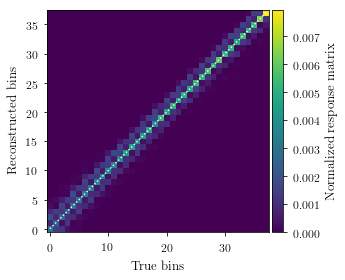

df_file = /data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/*.hdf
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.7s
[########################################] | 100% Completed |  5.7s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...


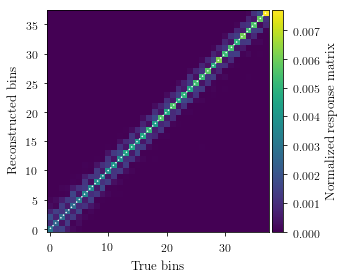

df_file = /data/user/jbourbeau/composition/IC86.2012/sim/sim_dataframe_vem_cal_down.hdf
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
Running energy reconstruction...
Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Making response matrix...


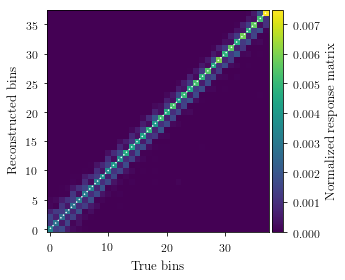

In [23]:
sim_files = {'up': '/data/user/jbourbeau/composition/IC86.2012/sim/sim_dataframe_vem_cal_down.hdf',
             'down': '/data/user/jbourbeau/composition/IC86.2012/sim/sim_dataframe_vem_cal_up.hdf',
             'nominal': '/data/user/jbourbeau/composition/IC86.2012/sim/processed_hdf/*.hdf',
            }
unfolded_results = {key: get_unfolded_counts(file) for key, file in sim_files.items()}

In [24]:
unfolded_results

{'down':    num_iterations                                           stat_err  \
 0               1  [128305.77961421985, 81738.46626640207, 60106....   
 1               2  [155314.22274521942, 115131.20057555899, 70491...   
 2               3  [178661.69823402006, 145584.39791497006, 83352...   
 3               4  [199622.79954537062, 174120.71261031693, 94620...   
 4               5  [218553.42862384333, 200440.86497891665, 10434...   
 5               6  [235642.94759034866, 224426.76507562512, 11271...   
 6               7  [251076.55216602184, 246125.98283458242, 11999...   
 
                                              sys_err   ts_iter  ts_stopping  \
 0  [20482777.120137677, 12740940.332878238, 77811...  0.094019        0.005   
 1  [25544052.52682695, 18156232.925562568, 895485...  0.012997        0.005   
 2  [29947232.853022896, 23424093.94487529, 103394...  0.008330        0.005   
 3  [33888462.08539723, 28337618.00213778, 1169567...  0.007519        0.005   
 4  [3

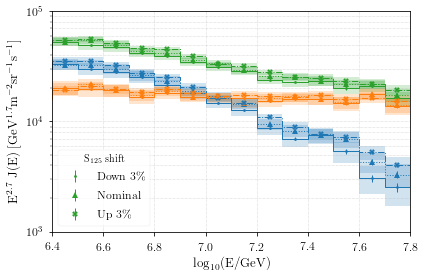

In [27]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(10, 5))
linestyles = iter(['-', ':', '-.', '--'])
markers = iter(['.', '^', 'X'])
for shift_type, df_unfolded in unfolded_results.items():
    marker = next(markers)
    ls = next(linestyles)
#     if prior_name != 'H4a':
#         continue
    counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(df_unfolded,
                                                                        num_groups=num_groups)
    for composition in comp_list + ['total']:
#         print(composition)
#         print(counts[composition])
        flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                            counts_err=counts_sys_err[composition],
                                            composition=composition)
        flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                             counts_err=counts_stat_err[composition],
                                             composition=composition)
        comp.plot_steps(energybins.log_energy_bins, flux,
                        yerr=flux_sys_err,
                        color=color_dict[composition],
                        ls=ls,
                        ax=ax)
#         label = '{} ({})'.format(composition, prior_name.replace('_', '-'))
        if composition == 'total':
            label = shift_type.capitalize() if shift_type == 'nominal' else '{} 3\%'.format(shift_type.capitalize())
        else:
            label = ''
        ax.errorbar(energybins.log_energy_midpoints, flux,
                    yerr=flux_stat_err,
                    color=color_dict[composition],
                    ls='None',
                    marker=marker,
                    capsize=20,
                    elinewidth=1,
                    label=label)
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=0.5, which='both')
ax.legend(title='$\mathrm{S_{125}}$ shift')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.75),
#           ncol=2,
#           fancybox=True)

outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'vem-calibration-flux-comparison.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

In [31]:
unfolded_counts = {}
for shift_type, df_unfolded in unfolded_results.items():
    counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(df_unfolded,
                                                                        num_groups=num_groups)
    unfolded_counts[shift_type] = {composition: counts[composition] for composition in comp_list + ['total']}
unfolded_counts

{'down': {'heavy': array([1.75490298e+08, 5.70940008e+07, 3.88404627e+07, 3.28623798e+07,
         2.16162139e+07, 1.44971314e+07, 8.39082462e+06, 6.24380101e+06,
         3.87350153e+06, 2.57026406e+06, 1.73228930e+06, 1.08610130e+06,
         7.72353402e+05, 5.25149205e+05, 3.22131203e+05, 2.66761064e+05,
         1.38263480e+05, 9.48625777e+04, 5.36068912e+04]),
  'light': array([2.46296890e+08, 9.11841785e+07, 7.30159611e+07, 5.42192235e+07,
         3.34170034e+07, 2.10462009e+07, 1.28403759e+07, 7.30104780e+06,
         4.16169164e+06, 2.32412132e+06, 1.33326974e+06, 6.25545747e+05,
         3.36682805e+05, 2.44179838e+05, 1.18530182e+05, 4.57490147e+04,
         2.53783548e+04, 1.53080830e+04, 1.05424341e+04]),
  'total': array([4.21787188e+08, 1.48278179e+08, 1.11856424e+08, 8.70816033e+07,
         5.50332174e+07, 3.55433323e+07, 2.12312006e+07, 1.35448488e+07,
         8.03519317e+06, 4.89438538e+06, 3.06555905e+06, 1.71164705e+06,
         1.10903621e+06, 7.69329043e+05, 4.4

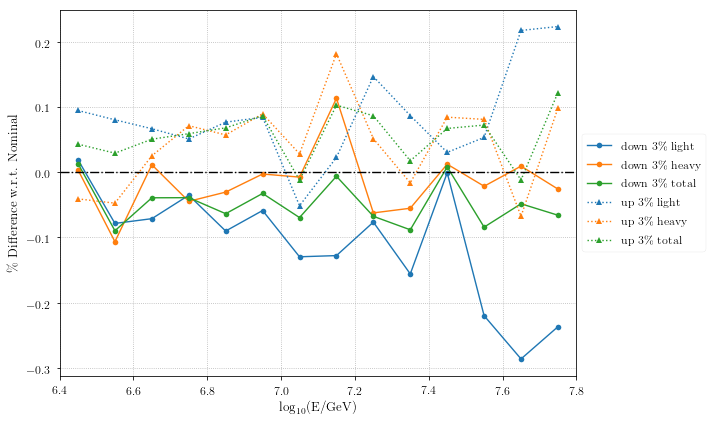

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))
# unfolded_counts = {}
linestyles = iter(['-', ':', '-.', '--'])
markers = iter(['o', '^', 'X'])
vem_systematic = []
for shift_type in ['down', 'up']:
    shift_systematic = {}
    marker = next(markers)
    ls = next(linestyles)
    for composition in comp_list + ['total']:
        nominal = unfolded_counts['nominal'][composition]
        deviation = (unfolded_counts[shift_type][composition] - nominal) / nominal
        energy_mask = np.logical_and(energybins.log_energy_midpoints < 7.8,
                                     energybins.log_energy_midpoints > 6.4)
        ax.plot(energybins.log_energy_midpoints[energy_mask], deviation[energy_mask],
                color=color_dict[composition],
                marker=marker,
                ls=ls,
                label='{} 3\% {}'.format(shift_type, composition))
        shift_systematic[composition] = np.mean(np.abs(deviation[energy_mask]))
        
    vem_systematic.append(shift_systematic)

ax.axhline(0.0, marker='None', ls='-.', color='k')
ax.set(xlabel='$\mathrm{\log_{10}(E/GeV)}$',
       xlim=(6.4, 7.8),
       ylabel='\% Difference w.r.t. Nominal')
ax.grid()
# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'vem-calibration-counts-deviation.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

In [87]:
np.stack((unfolded_counts['down']['total'], unfolded_counts['up']['total'])).max(axis=0)

array([4.21787188e+08, 1.78575504e+08, 1.22990232e+08, 8.96514414e+07,
       6.22358594e+07, 3.88707635e+07, 2.34030880e+07, 1.54522356e+07,
       9.02711613e+06, 5.19637280e+06, 3.40223332e+06, 1.99521295e+06,
       1.23793041e+06, 8.14436940e+05, 5.16083975e+05, 3.24521887e+05,
       1.96651892e+05, 1.24681248e+05, 8.54139339e+04])

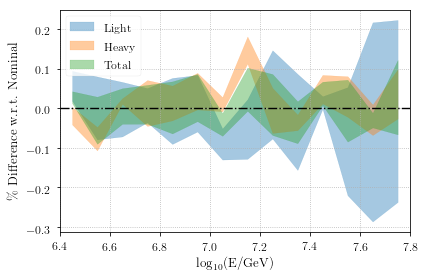

In [98]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(10, 6))
for composition in comp_list + ['total']:
    nominal = unfolded_counts['nominal'][composition]
    
    max_counts = np.stack((unfolded_counts['down'][composition], unfolded_counts['up'][composition])).max(axis=0)
    min_counts = np.stack((unfolded_counts['down'][composition], unfolded_counts['up'][composition])).min(axis=0)
    
    deviation_upper = (max_counts - nominal) / nominal
    deviation_lower = (min_counts - nominal) / nominal
    energy_mask = np.logical_and(energybins.log_energy_midpoints < 7.8,
                                 energybins.log_energy_midpoints > 6.4)
    ax.fill_between(energybins.log_energy_midpoints[energy_mask],
                    deviation_upper[energy_mask],
                    deviation_lower[energy_mask],
                    color=color_dict[composition],
                    alpha=0.4,
                    label=composition.capitalize())

ax.axhline(0.0, marker='None', ls='-.', color='k')
ax.set(xlabel='$\mathrm{\log_{10}(E/GeV)}$',
       xlim=(6.4, 7.8),
       ylabel='\% Difference w.r.t. Nominal')
ax.grid()
ax.legend(loc='upper left')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'vem-calibration-counts-deviation-bands.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

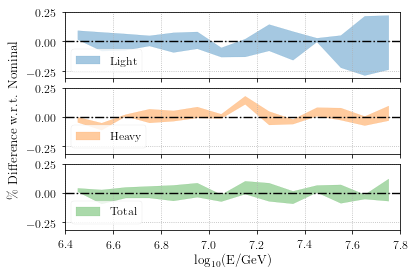

In [126]:
fig, axes = plt.subplots(ncols=1, nrows=3,
                         sharey=True, sharex=True,
                         gridspec_kw={'hspace':0.15})

for idx, (composition, ax) in enumerate(zip(comp_list + ['total'], axes)):
   
    nominal = unfolded_counts['nominal'][composition]
    
    max_counts = np.stack((unfolded_counts['down'][composition], unfolded_counts['up'][composition])).max(axis=0)
    min_counts = np.stack((unfolded_counts['down'][composition], unfolded_counts['up'][composition])).min(axis=0)
    
    deviation_upper = (max_counts - nominal) / nominal
    deviation_lower = (min_counts - nominal) / nominal
    energy_mask = np.logical_and(energybins.log_energy_midpoints < 7.8,
                                 energybins.log_energy_midpoints > 6.4)
    ax.fill_between(energybins.log_energy_midpoints[energy_mask],
                    deviation_upper[energy_mask],
                    deviation_lower[energy_mask],
                    color=color_dict[composition],
                    alpha=0.4,
                    label=composition.capitalize())

    ax.axhline(0.0, marker='None', ls='-.', color='k')
    ax.set_xlim(6.4, 7.8)
    if idx == 1:
        ax.set_ylabel('\% Difference w.r.t. Nominal')
    ax.grid()
    ax.legend(loc='lower left')
    
ax.set(xlabel='$\mathrm{\log_{10}(E/GeV)}$')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

outfile = os.path.join(comp.paths.figures_dir,
                       'systematics',
                       'vem-calibration-counts-deviation-bands-2.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.tight_layout()
plt.show()

In [78]:
vem_systematic = pd.DataFrame.from_records(vem_systematic, index=['down', 'up'])

In [115]:
vem_systematic

,heavy,light,total
down,0.036202,0.113349,0.051018
up,0.067410,0.092218,0.059518


In [28]:
# fig, ax = plt.subplots()
# im = ax.imshow(response, origin='lower', cmap='viridis')
# ax.plot([0, response.shape[0] - 1], [0, response.shape[1] - 1], marker='None', ls=':', color='white')
# comp.plotting.colorbar(im, label='Normalized response matrix')

# ax.set_xlabel('True bins')
# ax.set_ylabel('Reconstructed bins')

# plt.show()

In [23]:
# Run unfolding for each of the priors
names = ['uniform', 'H3a', 'H4a', 'simple_power_law']
# names = ['Jeffreys', 'H3a', 'H4a', 'Polygonato']
unfolding_results = {}
for prior_name in names:
    prior = None if prior_name == 'uniform' else df_priors['{}_prior'.format(prior_name)]
    # priors = 'Jeffreys' if prior_name == 'Jeffreys' else df['{}_prior'.format(prior_name)]
    df_unfolding_iter = pyunfold.iterative_unfold(data=counts_pyunfold,
                                                  data_err=counts_err_pyunfold,
                                                  response=response,
                                                  response_err=response_err,
                                                  efficiencies=efficiencies,
                                                  efficiencies_err=efficiencies_err,
                                                  ts='ks',
                                                  ts_stopping=0.005,
                                                  prior=prior,
                                                  return_iterations=True)
#                                                   callbacks=[pyunfold.callbacks.SplineRegularizer(degree=1, smooth=256)])
    unfolding_results[prior_name] = df_unfolding_iter

In [24]:
names

['uniform', 'H3a', 'H4a', 'simple_power_law']

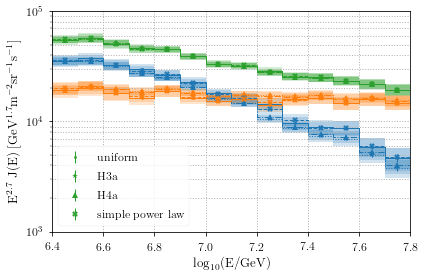

In [25]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(10, 5))
linestyles = ['-', ':', '-.', '--']
markers = ['.', '*', '^', 'X']
for prior_name, ls, marker in zip(names, linestyles, markers):
#     if prior_name != 'H4a':
#         continue
    counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolding_results[prior_name],
                                                                        num_groups=num_groups)
    for composition in comp_list + ['total']:
#         print(composition)
#         print(counts[composition])
        flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                            counts_err=counts_sys_err[composition],
                                            composition=composition)
        flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                             counts_err=counts_stat_err[composition],
                                             composition=composition)
        comp.plot_steps(energybins.log_energy_bins, flux,
                        yerr=flux_sys_err,
                        color=color_dict[composition],
                        ls=ls,
                        ax=ax)
#         label = '{} ({})'.format(composition, prior_name.replace('_', '-'))
        label = prior_name.replace('_', ' ') if composition == 'total' else ''
        ax.errorbar(energybins.log_energy_midpoints, flux,
                    yerr=flux_stat_err,
                    color=color_dict[composition],
                    ls='None',
                    marker=marker,
                    capsize=20,
                    elinewidth=1,
                    label=label)
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=1, which='both')
ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.75),
#           ncol=2,
#           fancybox=True)

# outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'allsky.png')
# comp.check_output_dir(outfile)
# plt.savefig(outfile)

plt.show()

In [220]:
unfolding_results[prior_name]

,num_iterations,stat_err,sys_err,ts_iter,ts_stopping,unfolded
0,1,"[103070.02504396967, 102144.86379256786, 50670...","[15749287.516949983, 15916022.452854631, 63263...",0.092134,0.005,"[191757396.1416671, 185164877.99562967, 100489..."
1,2,"[131953.06978832203, 129540.18108453172, 63206...","[20462526.446218558, 20765857.73598618, 772244...",0.013259,0.005,"[194439030.48473287, 183098573.05224302, 97407..."
2,3,"[156768.8273093421, 154851.65411568832, 76436....","[24771671.80102233, 25258328.6961266, 9280394....",0.006603,0.005,"[199315688.28344995, 184217275.63812009, 95749..."
3,4,"[179558.32058617944, 178243.33187288075, 88589...","[28715669.559097447, 29414788.434875157, 10789...",0.006247,0.005,"[203645760.02327502, 185650774.9339217, 942914..."
4,5,"[200461.48714098573, 199795.5892395803, 99408....","[32313868.88569669, 33238876.805621095, 121820...",0.005381,0.005,"[207218369.0219479, 187062412.3038028, 9288674..."
5,6,"[219513.50583395315, 219594.3790580178, 108934...","[35591637.47533877, 36746004.07863727, 1344948...",0.004610,0.005,"[210131297.34194955, 188430133.6614856, 915163..."


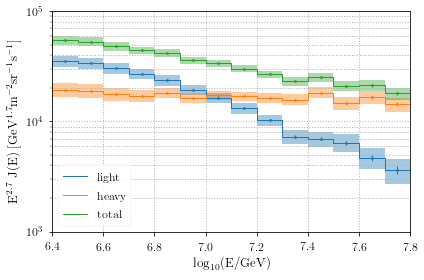

In [224]:
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(10, 5))

prior_name = 'H4a'
marker = '.'
ls = '-'
counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolding_results[prior_name],
                                                                    num_groups=num_groups)
for composition in comp_list + ['total']:
    flux, flux_sys_err = counts_to_flux(counts=counts[composition],
                                        counts_err=counts_sys_err[composition],
                                        composition=composition)
    flux, flux_stat_err = counts_to_flux(counts=counts[composition],
                                         counts_err=counts_stat_err[composition],
                                         composition=composition)
    comp.plot_steps(energybins.log_energy_bins, flux,
                    yerr=flux_sys_err,
                    color=color_dict[composition],
                    fillalpha=0.4,
                    ls=ls,
                    label=composition,
                    ax=ax)
    ax.errorbar(energybins.log_energy_midpoints, flux,
                yerr=flux_stat_err,
                color=color_dict[composition],
                ls='None',
                marker=marker,
                capsize=20,
                elinewidth=1)

ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim(6.4, 7.8)
ax.set_ylim(1e3, 1e5)
ax.grid(lw=1, which='both')

ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center',
#           bbox_to_anchor=(0.5, 1.75),
#           ncol=2,
#           fancybox=True)

outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'allsky.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()